# **Automated Machine Learning**

---

### **Reptile-Based Few-Shot Intrusion Detection System**
 *Author: Vladislav Zagidulin (2026)*<br>
 *Supervisor: Prof. Marwa Elsayed*

---

<font size="1"> Based on the Reptile meta-learning algorithm proposed by Alex Nichol and John Schulman [[1]](https://openai.com/research/reptile) and draws from the Torch Reptile implementation by Ruduan B. F. Plug [[2]](https://github.com/dualslash/reptile-torch)</font>
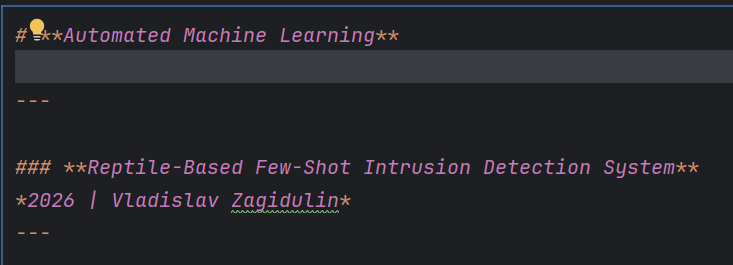

### Meta Libraries

In [289]:
# System Utility
import sys

# IPython Notebook Utilities
from IPython.display import clear_output
import tqdm.notebook as tqdm
clear_output()

print(sys.version)

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


### Packages

In [290]:
# Data Processing
import numpy as np

# Parallel Compute
import torch 
import torch.nn as nn

# Data Visualization
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Utility Libraries
from time import time
from copy import deepcopy

# Initialize Device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch Version\t", torch.__version__)

Torch Version	 2.9.0+cpu


### Environment Configuration

In [291]:
data_folder = "data"

FIXED_SEED = False

if FIXED_SEED:
    seed_val = 42
    print(f"Running a fixed seed (Seed: {seed_val})")
else:
    seed_val = int(time())
    print(f"Running a random seed (Seed: {seed_val})")

np.random.seed(seed_val)
torch.manual_seed(seed_val)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

Running a random seed (Seed: 1769709868)


### Meta-Learning Framework

#### Reptile Class Definition

In [292]:
from sklearn.metrics import precision_score, recall_score, f1_score

class Reptile:

  def __init__(self, model, log, params):

    # Intialize Reptile Parameters
    self.inner_step_size = params[0]
    self.inner_steps = params[1]
    self.outer_step_size = params[2]
    self.outer_iterations = params[3]
    self.meta_batch_size = params[4]
    self.criterion = nn.CrossEntropyLoss()

    # Initialize Torch Model and Tensorboard
    self.model = model.to(device)
    self.log = log

  def reset(self):

    # Reset Training Gradients
    self.model.zero_grad()

  def train(self, x, y):

    # Reset gradients
    self.reset()
    self.model.train()

    # Outer Training Loop
    for outer_iteration in tqdm.tqdm(range(self.outer_iterations)):

      # Track Current Weights
      current_weights = deepcopy(self.model.state_dict())

      # Sample a new Subtask
      (x_support, y_support), (x_query, y_query) = sample_task(
         x, y,
         allowed_classes=train_classes,
         n_way=N_WAY,
         k_shot=K_SHOT,
         query_size=QUERY_SIZE
      )

      x_support = x_support.to(device)
      y_support = y_support.to(device)
      x_query   = x_query.to(device)
      y_query   = y_query.to(device)

      # Inner Training Loop
      for inner_iteration in range(self.inner_steps):

        perm = torch.randperm(x_support.shape[0])

        # Process Meta Learning Batches
        for batch in range(0, x_support.shape[0], self.meta_batch_size):

          # Get Permuted Batch from Sample
          idx = perm[batch:batch + self.meta_batch_size]

          # Calculate Batch Loss
          self.model.zero_grad()
          batch_loss = self.loss(x_support[idx], y_support[idx])
          batch_loss.backward()

          # Update Model Parameters
          with torch.no_grad():
            for theta in self.model.parameters():
                if theta.grad is not None:
                    theta.add_(theta.grad, alpha=-self.inner_step_size)

      # Compute meta-loss
      with torch.no_grad():
         query_loss = self.loss(x_query, y_query)

      # Linear Cooling Schedule
      alpha = self.outer_step_size * (1 - outer_iteration / self.outer_iterations)

      # Get Current Candidate Weights
      candidate_weights = self.model.state_dict()

      # Transfer Candidate Weights to Model State Checkpoint
      state_dict = {candidate: (current_weights[candidate] + alpha * 
                               (candidate_weights[candidate] - current_weights[candidate])) 
                                for candidate in candidate_weights}
      self.model.load_state_dict(state_dict)
      
      # Log new Training Loss
      self.log.add_scalar('ModelEstimate/Loss', query_loss.item(), outer_iteration)

      # Log evaluation accuracy and precision
      if outer_iteration % 50 == 0:
        mean_acc, _, mean_prec, _, mean_rec, _, mean_f1, _ = evaluate_episodes(self, x_test, y_test, allowed_classes=test_classes, n_episodes=50)

        self.log.add_scalar('Episode/MeanAccuracy', mean_acc, outer_iteration)
        self.log.add_scalar('Episode/MeanPrecision', mean_prec, outer_iteration)
        self.log.add_scalar('Episode/MeanRecall', mean_rec, outer_iteration)
        self.log.add_scalar('Episode/MeanF1', mean_f1, outer_iteration)

  def loss(self, x, y):
    logits = self.model(x)
    return self.criterion(logits, y)

  def predict(self, x):
    self.model.eval()

    with torch.no_grad():
        # Convert only if needed
        if isinstance(x, torch.Tensor):
            t = x
        else:
            t = torch.as_tensor(x)

        # Ensure correct device and dtype
        t = t.to(device=device, dtype=torch.float32)

        logits = self.model(t)
        prediction = torch.argmax(logits, dim=1)

    return prediction.cpu().numpy()

  def eval(self, x, y, allowed_classes, gradient_steps=5):
      self.model.train()

      # Sample a task
      (x_support, y_support), (x_query, y_query) = sample_task(
         x, y,
         allowed_classes=allowed_classes,
         n_way=N_WAY,
         k_shot=K_SHOT,
         query_size=QUERY_SIZE
      )

      x_support = x_support.to(device)
      y_support = y_support.to(device)
      x_query   = x_query.to(device)
      y_query   = y_query.to(device)

      # Store Meta-Initialization Weights
      meta_weights = deepcopy(self.model.state_dict())

      # Calculate Estimate over Gradient Steps
      for step in range(gradient_steps):

        # Calculate Evaluation Loss and Backpropagate
        self.model.zero_grad()
        loss = self.loss(x_support, y_support)
        loss.backward()

        # Update Model Estimate Parameters
        with torch.no_grad():
          for theta in self.model.parameters():
              if theta.grad is not None:
                  theta.add_(theta.grad, alpha=-self.inner_step_size)

      # Get Estimate Loss over Evaluation
      self.model.eval()
      with torch.no_grad():
          logits = self.model(x_query)
          predictions = torch.argmax(logits, dim=1)

      # Accuracy
      accuracy = (predictions == y_query).float().mean().item()

      # Precision
      precision = precision_score(
          y_query.cpu().numpy(),
          predictions.cpu().numpy(),
          average='macro',
          zero_division=0
      )

      # Recall
      recall = recall_score(
          y_query.cpu().numpy(),
          predictions.cpu().numpy(),
          average='macro',
          zero_division=0
      )

      # F1 Score
      f1 = f1_score(
          y_query.cpu().numpy(),
          predictions.cpu().numpy(),
          average='macro',
          zero_division=0
      )

      # Restore Meta-Initialization Weights
      self.model.load_state_dict(meta_weights)
      self.model.train()

      return accuracy, precision, recall, f1

def evaluate_episodes(model, x, y, allowed_classes, n_episodes, gradient_steps=5):
    accs, precs, recs, f1s = [], [], [], []
    for _ in range(n_episodes):
        acc, prec, rec, f1 = model.eval(x, y, allowed_classes=allowed_classes, gradient_steps=gradient_steps)
        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
    return (
        np.mean(accs), np.std(accs),
        np.mean(precs), np.std(precs),
        np.mean(recs), np.std(recs),
        np.mean(f1s), np.std(f1s)
    )

#### Task Sampler

In [293]:
N_WAY = 3       # number of classes per episode
K_SHOT = 5      # support samples per class
QUERY_SIZE = 15  # query samples per class
HIDDEN_DIM = 128

def sample_task(x, y, allowed_classes, n_way=N_WAY, k_shot=K_SHOT, query_size=QUERY_SIZE, return_classes=False):
    # Work with numpy view of labels
    y_np = y.cpu().numpy()
    needed = k_shot + query_size

    # Only classes that are allowed and have enough samples
    valid_classes = [
        c for c in allowed_classes
        if np.sum(y_np == c) >= needed
    ]

    if len(valid_classes) < n_way:
        raise ValueError("Not enough valid classes for this N-way task")

    # Randomly choose n_way classes from the valid ones
    classes = np.random.choice(valid_classes, n_way, replace=False)

    support_x = []
    support_y = []
    query_x = []
    query_y = []

    # Map global label -> episodic label 0..n_way-1
    class_mapping = {int(c): i for i, c in enumerate(classes)}

    for c in classes:
        idx = np.where(y_np == c)[0]             # indices of this class
        chosen = np.random.choice(idx, needed, replace=False)

        support = chosen[:k_shot]
        query = chosen[k_shot:]

        support_x.append(x[support])
        query_x.append(x[query])

        # Episodic labels 0..n_way-1
        episodic_label = class_mapping[int(c)]
        support_y.append(torch.full((len(support),), episodic_label, dtype=torch.long))
        query_y.append(torch.full((len(query),), episodic_label, dtype=torch.long))

    x_support = torch.cat(support_x, dim=0)
    y_support = torch.cat(support_y, dim=0)
    x_query = torch.cat(query_x, dim=0)
    y_query = torch.cat(query_y, dim=0)

    if return_classes:
        return (x_support, y_support), (x_query, y_query), classes
    else:
        return (x_support, y_support), (x_query, y_query)


#### PyTorch Module

In [294]:
class TorchModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, num_classes=N_WAY):
        super(TorchModule, self).__init__()

        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, return_features=False):
        x = torch.relu(self.input(x))
        features = torch.relu(self.hidden(x))
        logits = self.output(features)

        if return_features:
            return logits, features
        return logits


### Dataset

#### Preprocessing

In [295]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("dataset/ML-EdgeIIoT-dataset-test.csv", low_memory=False)

# Remove duplicate entries
df.drop_duplicates(subset=None, keep="first", inplace=True)

# Keep the most important features
keep_cols = {
    "tcp.connection.rst",
    "tcp.connection.syn",
    "tcp.seq",
    "tcp.ack",
    "tcp.flags",
    'http.request.version',
    "Attack_type",
}

drop_cols = [c for c in df.columns if c not in keep_cols]
df.drop(columns=drop_cols, inplace=True)

# Clean values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

# Encode categorical features
categorical_cols = [
    'http.request.version',
]

df = pd.get_dummies(df, columns=categorical_cols)

# Separate features and labels
x_raw = df.drop(columns=["Attack_type"]).values

# Encode Attack_type labels
encoder = LabelEncoder()
y_raw = encoder.fit_transform(df["Attack_type"])

print("Dataset loaded:", x_raw.shape, y_raw.shape)

Dataset loaded: (156986, 13) (156986,)


#### Split Data

In [296]:
# Get all unique class labels
all_classes = np.unique(y_raw)

# Isolate normal traffic from attack traffic
normal_label = encoder.transform(['Normal'])[0]
attack_classes = [c for c in all_classes if c != normal_label]

# Choose 80% classes for meta-training
num_train_attacks = int(np.ceil(0.8 * len(attack_classes)))
train_attacks = np.random.choice(attack_classes, size=num_train_attacks, replace=False)
test_attacks  = [c for c in attack_classes if c not in train_attacks]

# Split normal class by rows to ensure no leakage into test set
normal_idx = np.where(y_raw == normal_label)[0]
np.random.shuffle(normal_idx)

cut = int(0.8 * len(normal_idx))
normal_train_idx = normal_idx[:cut]
normal_test_idx  = normal_idx[cut:]

# Get indices for the chosen train/test attack types
attack_train_idx = np.where(np.isin(y_raw, train_attacks))[0]
attack_test_idx  = np.where(np.isin(y_raw, test_attacks))[0]

# Combine
train_idx = np.concatenate([attack_train_idx, normal_train_idx])
test_idx  = np.concatenate([attack_test_idx,  normal_test_idx])

# Shuffle indices
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

# Apply split
x_train_np = x_raw[train_idx]
y_train_np = y_raw[train_idx]

x_test_np  = x_raw[test_idx]
y_test_np  = y_raw[test_idx]

# Initialize scaler to standardize features
scaler = StandardScaler()

# Fit on train set and transform both train and test sets
x_train_scaled = scaler.fit_transform(x_train_np)
x_test_scaled = scaler.transform(x_test_np)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)

x_test  = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test  = torch.tensor(y_test_np, dtype=torch.long)

# Define final classes
train_classes = np.unique(y_train_np)
test_classes  = np.unique(y_test_np)

print("The model will learn these classes:")
print(encoder.inverse_transform(train_classes))

print("\nThe model will be tested on these classes:")
print(encoder.inverse_transform(test_classes))

# Increase sample of minority classes using SMOTE
# smote = SMOTE(k_neighbors=5, random_state=42)
#
# x_train_np = x_train.numpy()
# y_train_np = y_train.numpy()
# x_train_res, y_train_res = smote.fit_resample(x_train_np, y_train_np)

# print("Train set:", x_train.shape, y_train.shape)

The model will learn these classes:
['Backdoor' 'DDoS_HTTP' 'DDoS_ICMP' 'DDoS_UDP' 'Fingerprinting' 'MITM'
 'Normal' 'Password' 'Port_Scanning' 'Ransomware' 'SQL_injection'
 'Uploading' 'XSS']

The model will be tested on these classes:
['DDoS_TCP' 'Normal' 'Vulnerability_scanner']


## Experiments

### Results

In [297]:
# Define Experiment Parameters
inner_step_size = 0.02
inner_steps = 15

outer_step_size = 0.1
outer_iterations = 2000
meta_batch_size = 15

params = [inner_step_size, inner_steps,
          outer_step_size, outer_iterations, meta_batch_size]

# Build Model
input_dim = x_train.shape[1]
log = SummaryWriter(data_folder)
reptile_model = Reptile(TorchModule(input_dim, hidden_dim=HIDDEN_DIM, num_classes=N_WAY), log, params)

# Train Model
reptile_model.train(x_train, y_train)

log.close()

# Zero-day evaluation on unseen test classes
mean_acc, std_acc, mean_prec, std_prec, mean_rec, std_rec, mean_f1, std_f1 = evaluate_episodes(
    reptile_model,
    x_test, y_test,
    allowed_classes=test_classes,
    n_episodes=200,
)

ci_acc  = 1.96 * std_acc  / np.sqrt(200)
ci_prec = 1.96 * std_prec / np.sqrt(200)
ci_rec = 1.96 * std_rec / np.sqrt(200)
ci_f1 = 1.96 * std_f1 / np.sqrt(200)

print(f"Zero-Day {N_WAY}-Way Accuracy : {mean_acc:.4f} ± {ci_acc:.4f}")
print(f"Zero-Day {N_WAY}-Way Precision: {mean_prec:.4f} ± {ci_prec:.4f}")
print(f"Zero-Day {N_WAY}-Way Recall: {mean_rec:.4f} ± {ci_rec:.4f}")
print(f"Zero-Day {N_WAY}-Way F1-Score: {mean_f1:.4f} ± {ci_f1:.4f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Zero-Day 3-Way Accuracy : 0.9137 ± 0.0083
Zero-Day 3-Way Precision: 0.9271 ± 0.0071
Zero-Day 3-Way Recall: 0.9137 ± 0.0083
Zero-Day 3-Way F1-Score: 0.9121 ± 0.0085


### Visualization

#### t-SNE

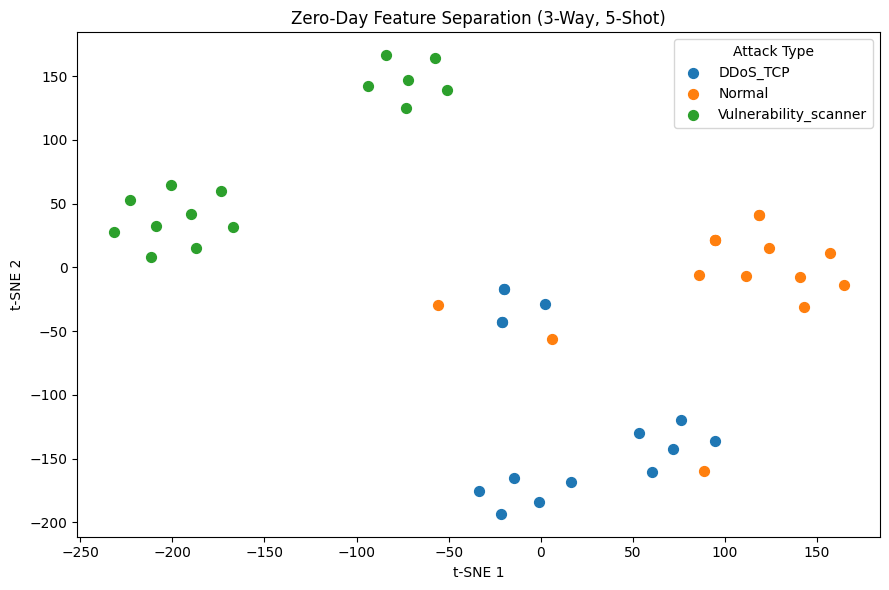

In [298]:
from sklearn.manifold import TSNE

# Sample zero-day task
(x_support, y_support), (x_query, y_query), classes = sample_task(
    x_test, y_test,
    allowed_classes=test_classes,
    n_way=N_WAY, k_shot=K_SHOT,
    query_size=QUERY_SIZE,
    return_classes=True
)

# Perform adaptation
meta_weights = deepcopy(reptile_model.model.state_dict())
reptile_model.model.train()

x_support, y_support = x_support.to(device), y_support.to(device)
x_query, y_query = x_query.to(device), y_query.to(device)

gradient_steps = 5

for _ in range(gradient_steps):
    reptile_model.model.zero_grad()
    loss = reptile_model.loss(x_support, y_support)
    loss.backward()
    with torch.no_grad():
        for p in reptile_model.model.parameters():
            if p.grad is not None:
                p -= reptile_model.inner_step_size * p.grad

# Extract features
reptile_model.model.eval()
with torch.no_grad():
    _, features = reptile_model.model(x_query, return_features=True)
    features_np = features.cpu().numpy()

# t-SNE visualization
tsne = TSNE(
    n_components=2,
    perplexity=10,
    early_exaggeration=18,
    random_state=seed_val,
    init="pca",
    learning_rate="auto"
)

projections = tsne.fit_transform(features_np)

plt.figure(figsize=(9, 6))
attack_names = encoder.inverse_transform(classes)

for i in range(N_WAY):
    idx = (y_query.eq(i)).cpu().numpy()
    plt.scatter(projections[idx, 0], projections[idx, 1], label=attack_names[i], s=50)

plt.title(f"Zero-Day Feature Separation ({N_WAY}-Way, {K_SHOT}-Shot)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Attack Type")
plt.tight_layout()
plt.show()

# Restore original weights
reptile_model.model.load_state_dict(meta_weights);

%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir data